In [41]:
# Copyright (c) OpenMMLab. All rights reserved.
import mmcv
import numpy as np
import torch
from collections import OrderedDict
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt

a150_classes = (
    'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed',
    'windowpane', 'grass', 'cabinet', 'sidewalk', 'person', 'earth',
    'door', 'table', 'mountain', 'plant', 'curtain', 'chair', 'car',
    'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug',
    'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe',
    'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column',
    'signboard', 'chest of drawers', 'counter', 'sand', 'sink',
    'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path',
    'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door',
    'stairway', 'river', 'bridge', 'bookcase', 'blind', 'coffee table',
    'toilet', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove',
    'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar',
    'arcade machine', 'hovel', 'bus', 'towel', 'light', 'truck', 'tower',
    'chandelier', 'awning', 'streetlight', 'booth', 'television receiver',
    'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister',
    'escalator', 'ottoman', 'bottle', 'buffet', 'poster', 'stage', 'van',
    'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything',
    'swimming pool', 'stool', 'barrel', 'basket', 'waterfall', 'tent',
    'bag', 'minibike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank',
    'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake',
    'dishwasher', 'screen', 'blanket', 'sculpture', 'hood', 'sconce',
    'vase', 'traffic light', 'tray', 'ashcan', 'fan', 'pier', 'crt screen',
    'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass',
    'clock', 'flag')

c171_classes = (
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner',
    'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet',
    'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile',
    'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain',
    'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble',
    'floor-other', 'floor-stone', 'floor-tile', 'floor-wood',
    'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass',
    'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat',
    'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net',
    'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform',
    'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof',
    'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper',
    'snow', 'solid-other', 'stairs', 'stone', 'straw', 'structural-other',
    'table', 'tent', 'textile-other', 'towel', 'tree', 'vegetable',
    'wall-brick', 'wall-concrete', 'wall-other', 'wall-panel',
    'wall-stone', 'wall-tile', 'wall-wood', 'water-other', 'waterdrops',
    'window-blind', 'window-other', 'wood')

processed_c171_classes = (
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
    'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'television receiver',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner',
    'blanket', 'branch', 'bridge', 'building', 'bush', 'cabinet',
    'cage', 'cardboard', 'carpet', 'ceiling', 'ceiling',
    'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain',
    'desk', 'dirt track', 'door', 'fence', 'floor',
    'floor', 'floor', 'floor', 'floor',
    'flower', 'fog', 'food', 'fruit', 'furniture', 'grass',
    'gravel', 'ground', 'hill', 'house', 'leaves', 'light', 'mat',
    'metal', 'mirror', 'moss', 'mountain', 'mud', 'napkin', 'net',
    'paper', 'pavement', 'pillow', 'plant', 'plastic', 'platform',
    'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof',
    'rug', 'salad', 'sand', 'sea', 'shelf', 'sky', 'skyscraper',
    'snow', 'solid', 'stairs', 'stone', 'straw', 'structural',
    'table', 'tent', 'textile', 'towel', 'tree', 'vegetable',
    'wall', 'wall', 'wall', 'wall',
    'wall', 'wall', 'wall', 'water', 'waterdrops',
    'blind', 'windowpane', 'wood')

novel_cls = list(set(a150_classes) - set(processed_c171_classes))
novel_inds = [a150_classes.index(c) for c in novel_cls]

def intersect_and_union(pred_label,
                        label,
                        num_classes,
                        ignore_index,
                        label_map=dict(),
                        reduce_zero_label=False,
                        int16=False):
    if isinstance(pred_label, str):
        if pred_label.endswith(".png"):
            pred_label = torch.from_numpy(np.array(Image.open(pred_label)))
        elif pred_label.endswith(".pth"):
            pred_label = torch.load(pred_label).squeeze(0).cpu() + 1
        # pred_label = torch.from_numpy(np.load(pred_label))
    else:
        pred_label = torch.from_numpy((pred_label))

    if isinstance(label, str):
        label = torch.from_numpy(
            mmcv.imread(label, flag='unchanged', backend='pillow'))
    else:
        label = torch.from_numpy(label)

    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]
    print(pred_label.shape, pred_label.unique(), label.shape, label.unique())

    intersect = pred_label[pred_label == label]
    area_intersect = torch.histc(
        intersect.float(), bins=(num_classes), min=0, max=num_classes - 1)
    area_pred_label = torch.histc(
        pred_label.float(), bins=(num_classes), min=0, max=num_classes - 1)
    area_label = torch.histc(
        label.float(), bins=(num_classes), min=0, max=num_classes - 1)
    area_union = area_pred_label + area_label - area_intersect
    return area_intersect, area_union, area_pred_label, area_label


def total_intersect_and_union(results,
                              gt_seg_maps,
                              num_classes,
                              ignore_index,
                              label_map=dict(),
                              reduce_zero_label=False,
                              int16=False):
    total_area_intersect = torch.zeros((num_classes, ), dtype=torch.float64)
    total_area_union = torch.zeros((num_classes, ), dtype=torch.float64)
    total_area_pred_label = torch.zeros((num_classes, ), dtype=torch.float64)
    total_area_label = torch.zeros((num_classes, ), dtype=torch.float64)
    for result, gt_seg_map in zip(results, gt_seg_maps):
        area_intersect, area_union, area_pred_label, area_label = \
            intersect_and_union(
                result, gt_seg_map, num_classes, ignore_index,
                label_map, reduce_zero_label, int16)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label
    return total_area_intersect, total_area_union, total_area_pred_label, \
        total_area_label


def mean_iou(results,
             gt_seg_maps,
             num_classes,
             ignore_index,
             nan_to_num=None,
             label_map=dict(),
             reduce_zero_label=False,
             int16=False):
    iou_result = eval_metrics(
        results=results,
        gt_seg_maps=gt_seg_maps,
        num_classes=num_classes,
        ignore_index=ignore_index,
        metrics=['mIoU'],
        nan_to_num=nan_to_num,
        label_map=label_map,
        reduce_zero_label=reduce_zero_label,
        int16=int16)
    return iou_result


def total_area_to_metrics(total_area_intersect,
                          total_area_union,
                          total_area_pred_label,
                          total_area_label,
                          metrics=['mIoU'],
                          nan_to_num=None,
                          beta=1):
    if isinstance(metrics, str):
        metrics = [metrics]
    allowed_metrics = ['mIoU', 'mDice', 'mFscore']
    if not set(metrics).issubset(set(allowed_metrics)):
        raise KeyError('metrics {} is not supported'.format(metrics))

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    ret_metrics = OrderedDict({'aAcc': all_acc})
    for metric in metrics:
        iou = total_area_intersect / total_area_union
        acc = total_area_intersect / total_area_label
        ret_metrics['IoU'] = iou
        ret_metrics['Acc'] = acc
    
    ret_metrics = {
        metric: value.numpy()
        for metric, value in ret_metrics.items()
    }
    if nan_to_num is not None:
        ret_metrics = OrderedDict({
            metric: np.nan_to_num(metric_value, nan=nan_to_num)
            for metric, metric_value in ret_metrics.items()
        })
    ious = ret_metrics["IoU"]
    return np.nanmean(ious)


def eval_metrics(results,
                 gt_seg_maps,
                 num_classes,
                 ignore_index,
                 metrics=['mIoU'],
                 nan_to_num=None,
                 label_map=dict(),
                 reduce_zero_label=False,
                 int16=False,
                 beta=1):

    total_area_intersect, total_area_union, total_area_pred_label, \
        total_area_label = total_intersect_and_union(
            results, gt_seg_maps, num_classes, ignore_index, label_map,
            reduce_zero_label, int16)
    ret_metrics = total_area_to_metrics(total_area_intersect, total_area_union,
                                        total_area_pred_label,
                                        total_area_label, metrics, nan_to_num,
                                        beta)
    return ret_metrics

In [28]:
files = glob("../work_dirs/20221029_vitb16_320k_wa150_c171_ab0.1/pred/*.png")
image_ious = {}
for f in files:
    name = os.path.basename(f).rstrip(".png")
    miou = eval_metrics(
        [f"../work_dirs/20221029_vitb16_320k_wa150_c171_ab0.1/pred/{name}.png"], 
        [f'/mnt/haojun/itpsea4data/dataset/ADEChallengeData2016/annotations/validation/{name}.png'],
        150, 255
    )
    image_ious[name] = miou
# import json
# json.dump(image_ious, open("visualization/image_miou_a150_baseline_a150.json", "w"))
# import json
# image_ious = json.load(open("visualization/image_miou_a150.json"))

In [ ]:
files = glob("../work_dirs/20221106_vitb16_320k_wa150_c171_i124_ib8.0_ab8.0_co_ic4.0_ac4.0_wbce/pred/*.png")
image_ious = {}
for f in files:
    name = os.path.basename(f).rstrip(".png")
    miou = eval_metrics(
        [f"../work_dirs/20221106_vitb16_320k_wa150_c171_i124_ib8.0_ab8.0_co_ic4.0_ac4.0_wbce/pred/{name}.png"], 
        [f'/mnt/haojun/itpsea4data/dataset/ADEChallengeData2016/annotations/validation/{name}.png'],
        150, 255
    )
    image_ious[name] = miou
import json
json.dump(image_ious, open("visualization/image_miou_a150_extenseg_a150.json", "w"))

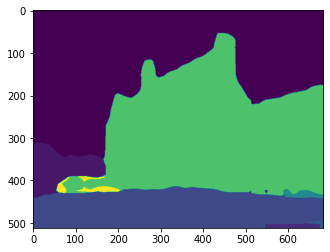

tensor([ 3,  5,  7, 10, 12, 18, 26, 35], dtype=torch.uint8)


In [19]:
files = glob("../work_dirs/20221105_vitb16_320k_c171_lseg/pred/*.png")
image_ious = {}
for f in files:
    name = os.path.basename(f).rstrip(".png")
    miou = eval_metrics(
        [f"../work_dirs/20221105_vitb16_320k_c171_lseg/pred/{name}.png"], 
        [f'/mnt/haojun/itpsea4data/dataset/ADEChallengeData2016/annotations/validation/{name}.png'],
        150, 255
    )
    image_ious[name] = miou
# import json
# json.dump(image_ious, open("visualization/image_miou_a150_lseg_c171.json", "w"))

In [42]:
files = glob("/mnt/haojun/itpsea4data/reco/prediction/*.pth")
image_ious = {}
for f in files:
    if "ADE_val_00000001.pth" not in f:
        continue
    name = os.path.basename(f).rstrip(".pth")
    miou = eval_metrics(
        [f"/mnt/haojun/itpsea4data/reco/prediction/{name}.pth"], 
        [f'/mnt/haojun/itpsea4data/dataset/ADEChallengeData2016/annotations/validation/{name}.png'],
        150, 255
    )
    image_ious[name] = miou
    print(miou)
# import json
# json.dump(image_ious, open("visualization/image_miou_a150_reco.json", "w"))

torch.Size([349696]) tensor([  1,   2,   3,   5,   7,   9,  10,  12,  15,  18,  23,  26,  30,  36,
         41,  49,  50,  52,  53,  61,  69,  72,  73,  74,  75,  80,  85,  88,
         92,  94,  95, 105, 106, 107, 124, 126, 129, 130, 137, 139, 141, 142,
        145, 149]) torch.Size([349696]) tensor([ 0,  1,  2,  3,  5,  7, 10, 18], dtype=torch.uint8)
0.03302687707901938


In [31]:
files = glob("/mnt/haojun/itpsea4data/zsseg.baseline/prediction/*.pth")
image_ious = {}
for f in files:
    name = os.path.basename(f).rstrip(".pth")
    miou = eval_metrics(
        [f"/mnt/haojun/itpsea4data/zsseg.baseline/prediction/{name}.pth"], 
        [f'/mnt/haojun/itpsea4data/dataset/ADEChallengeData2016/annotations/validation/{name}.png'],
        150, 255
    )
    image_ious[name] = miou
# import json
# json.dump(image_ious, open("visualization/image_miou_a150_zsbaseline.json", "w"))

In [32]:
import json
json.dump(image_ious, open("visualization/image_miou_a150_zsbaseline.json", "w"))

In [33]:
import json
ious_baseline = json.load(open("visualization/image_miou_a150_baseline_a150.json"))
ious_extenseg = json.load(open("visualization/image_miou_a150_extenseg_a150.json"))
ious_lseg = json.load(open("visualization/image_miou_a150_lseg_c171.json"))
ious_zsbaseline = json.load(open("visualization/image_miou_a150_zsbaseline.json"))
ious_reco = json.load(open("visualization/image_miou_a150_reco.json"))
print(
    ious_baseline["ADE_val_00000511"], 
    ious_extenseg["ADE_val_00000511"], 
    ious_lseg["ADE_val_00000511"],
    ious_zsbaseline["ADE_val_00000511"],
    ious_reco["ADE_val_00000511"]
)

0.38725556902530056 0.45855954912922736 0.2971537907090828 0.2712735490288198 0.04397004308053477


In [34]:
np.mean(list(ious_reco.values()))

0.02704033640321063

In [18]:
from tqdm import tqdm
for name in ious_baseline:
    label = np.array(
        Image.open(f"/mnt/haojun/itpsea4data/dataset/ADEChallengeData2016/annotations/validation/{name}.png"))
    label = (label - 1).astype(np.uint8)
    unique_label = np.unique(label)
    unique_label = (unique_label[unique_label != 255]).tolist() 
    novel_label = [l for l in unique_label if l in novel_inds]
    if len(novel_label) >= 1 and ious_baseline[name] > 0.4 and \
            ious_extenseg[name] > 0.4 and \
            ious_extenseg[name] > ious_baseline[name] and \
            ious_baseline[name] > ious_lseg[name] and \
            ious_baseline[name] > ious_reco[name] and \
            ious_baseline[name] > ious_zsbaseline[name]:
        print(name, len(novel_label), ious_baseline[name], image_ious[name])

ADE_val_00000114 1 0.40942709235664965 0.44695302775429885
ADE_val_00000816 2 0.5107132171235609 0.598547861707437
ADE_val_00000891 1 0.5027670468872545 0.6015315059567594
ADE_val_00000925 3 0.43869673207280685 0.5738595554409489
ADE_val_00000991 1 0.4441963407719868 0.5957264207990564
ADE_val_00001172 3 0.4983456389860619 0.6209901083695816
ADE_val_00001365 1 0.45182375554023413 0.4818678904347811
ADE_val_00001432 6 0.43050320369235784 0.4891640990790895


In [2]:
# files = glob("../work_dirs/20221104_vitb16_320k_wa150_c171_ab4.0_co_ac2.0_wbce/pred_c171/*.png")
# image_ious = {}
# from tqdm import tqdm
# for f in tqdm(files):
#     name = os.path.basename(f).rstrip(".png")
#     miou = eval_metrics(
#         [f"../work_dirs/20221104_vitb16_320k_wa150_c171_ab4.0_co_ac2.0_wbce/pred_c171/{name}.png"], 
#         [f'/mnt/haojun/itpsea4data/dataset/coco_stuff164k/annotations/validation/{name}_labelTrainIds.png'],
#         171, 255,
#         reduce_zero_label=True
#     )
#     image_ious[name] = miou

In [3]:
# import json
# json.dump(image_ious, open("visualization/image_miou_c171.json", "w"))

In [7]:
import mmcv
import numpy as np
import torch
from collections import OrderedDict
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt

# vis_files = glob("../vis_dirs/baseline_c171_eval_a150_novel_only/*.png")
# for f in vis_files:
#     name = os.path.basename(f)[:len("ADE_val_00000003")]
#     if image_ious[name] > 0.4 and "sofa" in f:
#         print(name, os.path.basename(f)[len("ADE_val_00000003"):].split("_")[1:], image_ious[name])
#         plt.figure(figsize=(50,5))
#         plt.imshow(Image.open(f))
#         plt.show()
#         plt.close()

In [ ]:
# for f in files:
#     name = os.path.basename(f).rstrip(".png")
#     label = np.array(Image.open(
#         f'/mnt/haojun/itpsea4data/dataset/coco_stuff164k/annotations/validation/{name}_labelTrainIds.png'
#     ))
#     if image_ious[name] > 0.8 and len(np.unique(label)) > 6:
#         print(len(np.unique(label)), name, image_ious[name])
#         img = Image.open(
#             f'/mnt/haojun/itpsea4data/dataset/coco_stuff164k/images/validation/{name}.jpg'
#         )
#         plt.imshow(img)
#         plt.show()
#         plt.close()
